# 机器学习实战课程

> **课程时长**: 1.5小时  
> **目标**: 通过MNIST数据集学习MLP、CNN、ResNet，然后进行YOLO目标检测实战

---

## 环境准备

首先安装和导入必要的库

In [18]:
# 安装必要的库（如果尚未安装）
# !pip install torch torchvision matplotlib ultralytics opencv-python

In [19]:
# ==================== 导入所有必要的库 ====================
import torch                                    # PyTorch深度学习框架
import torch.nn as nn                           # 神经网络模块
import torch.optim as optim                     # 优化器
import torch.nn.functional as F                 # 常用函数（如ReLU、Softmax等）
from torch.utils.data import DataLoader         # 数据加载器
import torchvision                              # 计算机视觉工具库
import torchvision.transforms as transforms     # 数据预处理/增强
from torchvision.datasets import MNIST          # MNIST数据集
import matplotlib.pyplot as plt                 # 绑图库
import numpy as np                              # 数值计算库

# 设置中文显示（如果需要）
plt.rcParams['font.sans-serif'] = ['SimHei']    # 用于正常显示中文
plt.rcParams['axes.unicode_minus'] = False      # 用于正常显示负号

# 检查是否有GPU可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "mps"

print(f'使用设备: {device}')

使用设备: mps


---

## Part 1: MNIST + 全连接网络 (MLP)

### 1.1 MNIST数据集介绍

- **MNIST**: 手写数字识别数据集，包含0-9共10类数字
- **规模**: 60000张训练图片，10000张测试图片
- **尺寸**: 28×28像素，灰度图
- **地位**: 机器学习的"Hello World"

In [20]:
# ==================== 1.2 加载MNIST数据集 ====================

# 定义数据预处理流程
transform = transforms.Compose([
    transforms.ToTensor(),                # 将PIL图像转换为Tensor，并归一化到[0,1]
    transforms.Normalize((0.1307,), (0.3081,))  # 使用MNIST的均值和标准差进行标准化
])

# 下载并加载训练集
# root: 数据存储路径
# train=True: 加载训练集
# download=True: 如果数据不存在则自动下载
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)

# 下载并加载测试集
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

# 创建数据加载器
# batch_size: 每批次加载64张图片
# shuffle: 训练时打乱数据顺序，测试时不打乱
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f'训练集大小: {len(train_dataset)}')
print(f'测试集大小: {len(test_dataset)}')
print(f'图片尺寸: {train_dataset[0][0].shape}')

训练集大小: 60000
测试集大小: 10000
图片尺寸: torch.Size([1, 28, 28])


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/var/folders/wk/8zl240wd3693mlqbl848bjj40000gn

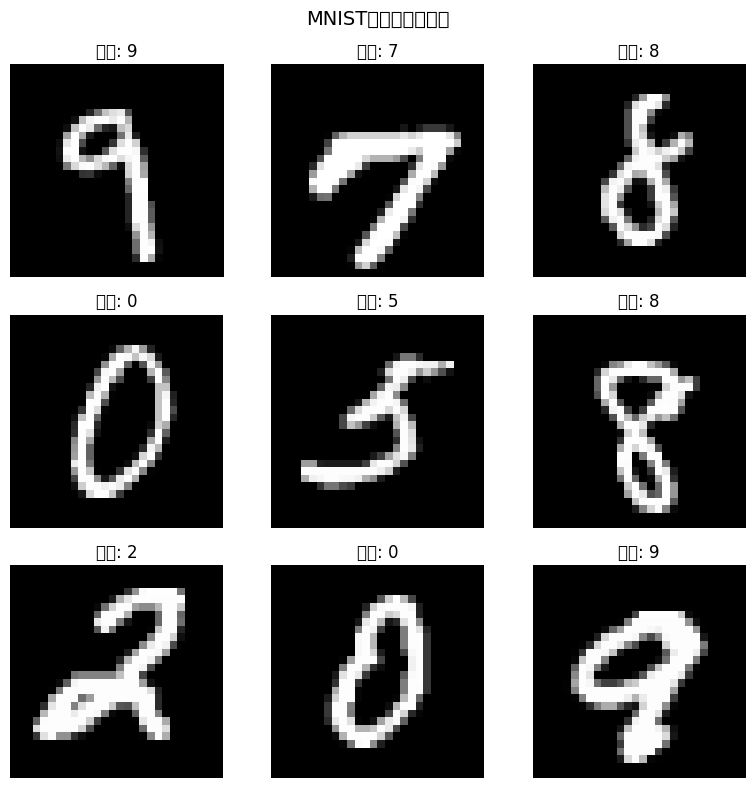

In [21]:
# ==================== 1.3 可视化MNIST样本 ====================

# 获取一批数据用于展示
images, labels = next(iter(train_loader))

# 创建3x3的子图
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    # 显示图片（需要squeeze去掉通道维度，因为是灰度图）
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(f'标签: {labels[i].item()}', fontsize=12)
    ax.axis('off')  # 隐藏坐标轴

plt.suptitle('MNIST数据集样本展示', fontsize=14)
plt.tight_layout()
plt.show()

### 1.4 全连接网络原理

**神经元工作方式**: 输入 → 加权求和 → 激活函数 → 输出

**网络结构**:
```
输入层(784) → 隐藏层(256) → 隐藏层(128) → 输出层(10)
```

**类比**: 把神经网络比作"投票系统"，每个神经元投票，最终多数票决定分类

In [22]:
# ==================== 1.5 定义全连接网络 (MLP) ====================

class MLP(nn.Module):
    """
    多层感知机（全连接神经网络）
    结构: 784 → 256 → 128 → 10
    """
    def __init__(self):
        super(MLP, self).__init__()
        
        # 第一个全连接层: 输入784维（28*28展平），输出256维
        self.fc1 = nn.Linear(28 * 28, 256)
        
        # 第二个全连接层: 输入256维，输出128维
        self.fc2 = nn.Linear(256, 128)
        
        # 第三个全连接层（输出层）: 输入128维，输出10维（对应10个数字类别）
        self.fc3 = nn.Linear(128, 10)
        
        # Dropout层: 训练时随机丢弃20%的神经元，防止过拟合
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        """
        前向传播
        x: 输入张量，形状为 (batch_size, 1, 28, 28)
        """
        # 步骤1: 将28x28的图片展平为784维向量
        x = x.view(-1, 28 * 28)  # (batch_size, 784)
        
        # 步骤2: 第一层 → ReLU激活 → Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        # 步骤3: 第二层 → ReLU激活 → Dropout
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        # 步骤4: 输出层（不需要激活函数，交给损失函数处理）
        x = self.fc3(x)
        
        return x

# 创建模型实例并移动到GPU（如果可用）
mlp_model = MLP().to(device)

# 打印模型结构
print(mlp_model)

# 计算模型参数量
total_params = sum(p.numel() for p in mlp_model.parameters())
print(f'\nMLP总参数量: {total_params:,}')

MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

MLP总参数量: 235,146


In [23]:
# ==================== 1.6 定义训练和测试函数 ====================

def train(model, train_loader, optimizer, criterion, device):
    """
    训练函数：执行一个epoch的训练
    
    参数:
        model: 神经网络模型
        train_loader: 训练数据加载器
        optimizer: 优化器
        criterion: 损失函数
        device: 运行设备（CPU/GPU）
    
    返回:
        平均训练损失
    """
    model.train()  # 设置为训练模式（启用Dropout等）
    total_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # 将数据移动到指定设备
        data, target = data.to(device), target.to(device)
        
        # 清零梯度（PyTorch默认会累积梯度）
        optimizer.zero_grad()
        
        # 前向传播：计算预测值
        output = model(data)
        
        # 计算损失
        loss = criterion(output, target)
        
        # 反向传播：计算梯度
        loss.backward()
        
        # 更新权重
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)


def test(model, test_loader, criterion, device):
    """
    测试函数：在测试集上评估模型
    
    返回:
        (平均测试损失, 准确率)
    """
    model.eval()  # 设置为评估模式（禁用Dropout等）
    test_loss = 0
    correct = 0
    
    # 不计算梯度，节省内存和计算
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # 前向传播
            output = model(data)
            
            # 累加损失
            test_loss += criterion(output, target).item()
            
            # 获取预测结果（概率最大的类别）
            pred = output.argmax(dim=1)
            
            # 统计正确预测的数量
            correct += pred.eq(target).sum().item()
    
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    return test_loss, accuracy

In [24]:
# ==================== 1.7 训练MLP模型 ====================

# 定义损失函数：交叉熵损失（适用于多分类问题）
criterion = nn.CrossEntropyLoss()

# 定义优化器：Adam优化器
# lr: 学习率，控制每次更新的步长
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# 训练参数
epochs = 5

# 记录训练过程
mlp_train_losses = []
mlp_test_losses = []
mlp_accuracies = []

print('开始训练MLP...\n')

for epoch in range(1, epochs + 1):
    # 训练一个epoch
    train_loss = train(mlp_model, train_loader, mlp_optimizer, criterion, device)
    
    # 在测试集上评估
    test_loss, accuracy = test(mlp_model, test_loader, criterion, device)
    
    # 记录结果
    mlp_train_losses.append(train_loss)
    mlp_test_losses.append(test_loss)
    mlp_accuracies.append(accuracy)
    
    # 打印进度
    print(f'Epoch {epoch}/{epochs}:')
    print(f'  训练损失: {train_loss:.4f}')
    print(f'  测试损失: {test_loss:.4f}')
    print(f'  测试准确率: {accuracy:.2f}%\n')

print(f'MLP最终准确率: {mlp_accuracies[-1]:.2f}%')

开始训练MLP...

Epoch 1/5:
  训练损失: 0.2762
  测试损失: 0.1211
  测试准确率: 96.20%

Epoch 2/5:
  训练损失: 0.1291
  测试损失: 0.0917
  测试准确率: 97.25%

Epoch 3/5:
  训练损失: 0.0998
  测试损失: 0.0826
  测试准确率: 97.52%

Epoch 4/5:
  训练损失: 0.0838
  测试损失: 0.0715
  测试准确率: 97.83%

Epoch 5/5:
  训练损失: 0.0711
  测试损失: 0.0766
  测试准确率: 97.69%

MLP最终准确率: 97.69%


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/var/folders/wk/8zl240wd3693mlqbl848bjj40000gn/T/ipykernel_52667/674060606.py:33: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from current font.
  plt.tight_layout()
/var/folders/wk/8zl240wd3693mlqbl848bjj40000gn/T/ipykernel_52667/674060606.py:33: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from current font.
  plt.tig

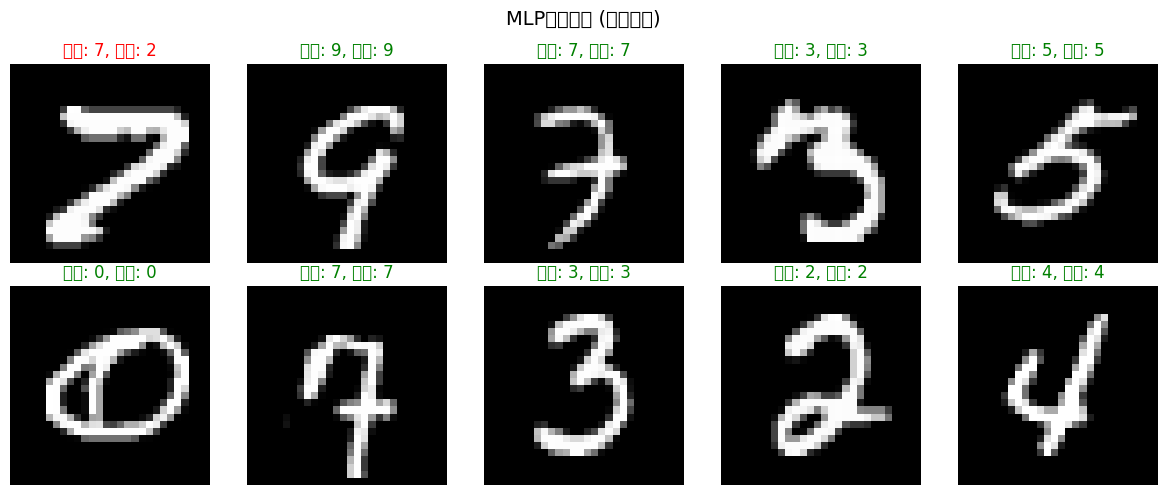

本次随机抽取的图片索引: [3441 5871 4238 2408 9786 4923 5914 4714 1132 5395]


In [25]:
# ==================== 1.8 可视化MLP预测结果 ====================

# 随机抽取10张测试图片进行预测展示
# 每次运行此cell都会随机抽取不同的图片
num_samples = 10
random_indices = np.random.choice(len(test_dataset), num_samples, replace=False)

# 获取随机抽取的图片和标签
test_images = torch.stack([test_dataset[i][0] for i in random_indices]).to(device)
test_labels = torch.tensor([test_dataset[i][1] for i in random_indices]).to(device)

# 进行预测
mlp_model.eval()
with torch.no_grad():
    predictions = mlp_model(test_images).argmax(dim=1)

# 可视化预测结果
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i, ax in enumerate(axes.flat):
    img = test_images[i].cpu().squeeze()
    true_label = test_labels[i].item()
    pred_label = predictions[i].item()
    
    ax.imshow(img, cmap='gray')
    
    # 预测正确显示绿色，错误显示红色
    color = 'green' if pred_label == true_label else 'red'
    ax.set_title(f'真实: {true_label}, 预测: {pred_label}', color=color)
    ax.axis('off')

plt.suptitle('MLP预测结果 (随机抽样)', fontsize=14)
plt.tight_layout()
plt.show()

print(f'本次随机抽取的图片索引: {random_indices}')

---

## Part 2: MNIST + CNN (卷积神经网络)

### 2.1 CNN核心概念

**卷积层 (Convolution)**:
- 用"滑动窗口"扫描图片，提取局部特征
- 卷积核就像"特征探测器"，检测边缘、纹理等

**池化层 (Pooling)**:
- 降低分辨率，保留重要信息
- 作用: 减少计算量，增强鲁棒性

**为什么CNN比全连接好**:
- 参数共享: 同一个卷积核扫描整张图
- 局部连接: 只关注邻近像素
- 平移不变性: 数字在哪都能识别

In [26]:
# ==================== 2.2 定义CNN模型 ====================

class CNN(nn.Module):
    """
    卷积神经网络
    结构: Conv1 → Pool → Conv2 → Pool → FC1 → FC2
    """
    def __init__(self):
        super(CNN, self).__init__()
        
        # 第一个卷积层
        # in_channels=1: 输入是灰度图（1个通道）
        # out_channels=32: 输出32个特征图
        # kernel_size=3: 使用3x3的卷积核
        # padding=1: 边缘填充1像素，保持尺寸不变
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        
        # 第二个卷积层: 32个通道输入，64个通道输出
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        # 最大池化层: 2x2窗口，步长为2，尺寸减半
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 全连接层
        # 经过两次池化后: 28→14→7，所以输入是 64*7*7
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        
        # Dropout防止过拟合
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        """
        前向传播
        x: (batch_size, 1, 28, 28)
        """
        # 第一个卷积块: Conv → ReLU → Pool
        # (batch, 1, 28, 28) → (batch, 32, 28, 28) → (batch, 32, 14, 14)
        x = self.pool(F.relu(self.conv1(x)))
        
        # 第二个卷积块: Conv → ReLU → Pool
        # (batch, 32, 14, 14) → (batch, 64, 14, 14) → (batch, 64, 7, 7)
        x = self.pool(F.relu(self.conv2(x)))
        
        # 展平: (batch, 64, 7, 7) → (batch, 64*7*7)
        x = x.view(-1, 64 * 7 * 7)
        
        # 全连接层
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# 创建CNN模型
cnn_model = CNN().to(device)
print(cnn_model)

# 计算参数量
cnn_params = sum(p.numel() for p in cnn_model.parameters())
print(f'\nCNN总参数量: {cnn_params:,}')

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

CNN总参数量: 421,642


In [27]:
# ==================== 2.3 训练CNN模型 ====================

# 定义优化器
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# 记录训练过程
cnn_train_losses = []
cnn_test_losses = []
cnn_accuracies = []

print('开始训练CNN...\n')

for epoch in range(1, epochs + 1):
    train_loss = train(cnn_model, train_loader, cnn_optimizer, criterion, device)
    test_loss, accuracy = test(cnn_model, test_loader, criterion, device)
    
    cnn_train_losses.append(train_loss)
    cnn_test_losses.append(test_loss)
    cnn_accuracies.append(accuracy)
    
    print(f'Epoch {epoch}/{epochs}:')
    print(f'  训练损失: {train_loss:.4f}')
    print(f'  测试损失: {test_loss:.4f}')
    print(f'  测试准确率: {accuracy:.2f}%\n')

print(f'CNN最终准确率: {cnn_accuracies[-1]:.2f}%')

开始训练CNN...

Epoch 1/5:
  训练损失: 0.1749
  测试损失: 0.0440
  测试准确率: 98.52%

Epoch 2/5:
  训练损失: 0.0617
  测试损失: 0.0299
  测试准确率: 99.01%

Epoch 3/5:
  训练损失: 0.0458
  测试损失: 0.0293
  测试准确率: 99.11%

Epoch 4/5:
  训练损失: 0.0390
  测试损失: 0.0268
  测试准确率: 99.07%

Epoch 5/5:
  训练损失: 0.0340
  测试损失: 0.0239
  测试准确率: 99.14%

CNN最终准确率: 99.14%


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

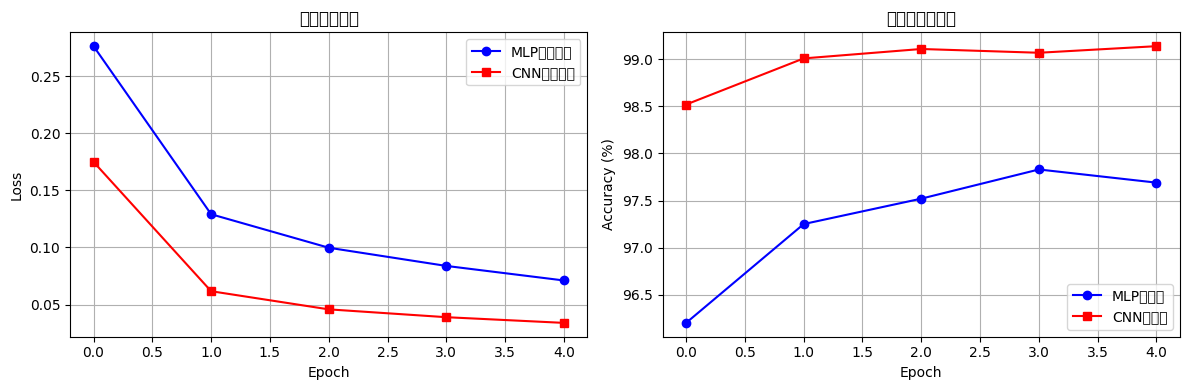

\n========== MLP vs CNN 对比 ==========
模型      | 参数量    | 最终准确率
MLP       |  235,146 | 97.69%
CNN       |  421,642 | 99.14%


In [28]:
# ==================== 2.4 训练曲线对比 ====================

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 损失曲线
axes[0].plot(mlp_train_losses, 'b-o', label='MLP训练损失')
axes[0].plot(cnn_train_losses, 'r-s', label='CNN训练损失')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('训练损失对比')
axes[0].legend()
axes[0].grid(True)

# 准确率曲线
axes[1].plot(mlp_accuracies, 'b-o', label='MLP准确率')
axes[1].plot(cnn_accuracies, 'r-s', label='CNN准确率')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('测试准确率对比')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# 打印对比结果
print('\\n========== MLP vs CNN 对比 ==========')
print(f'模型      | 参数量    | 最终准确率')
print(f'MLP       | {sum(p.numel() for p in mlp_model.parameters()):>8,} | {mlp_accuracies[-1]:.2f}%')
print(f'CNN       | {sum(p.numel() for p in cnn_model.parameters()):>8,} | {cnn_accuracies[-1]:.2f}%')

---

## Part 3: MNIST + ResNet (残差网络)

>  **说明**: 这里继续使用MNIST是为了方便与前两个模型对比。实际上ResNet是为ImageNet等复杂任务设计的，用于MNIST有点"杀鸡用牛刀"，但能帮助大家快速理解残差连接的核心思想。

### 3.1 ResNet核心思想

**深度网络的问题**: 网络越深，准确率反而可能下降（梯度消失/爆炸）

**残差连接 (Residual Connection)**:
- 核心公式: `输出 = F(x) + x`
- "跳跃连接": 让信息可以绕过某些层直接传递
- 类比: 高速公路的"直通道"，信息不会堵塞

```
    ┌─────────────────────┐
    │                     │ (跳跃连接)
x ──┼──→ [Conv] → [Conv] ─┼──→ (+) → ReLU → 输出
    └─────────────────────┘
```

In [29]:
# ==================== 3.2 定义残差块 ====================

class ResidualBlock(nn.Module):
    """
    残差块 (Residual Block)
    
    核心思想: 输出 = F(x) + x
    其中 F(x) 是两个卷积层的输出
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        # 第一个卷积层
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)  # 批归一化，加速训练
        
        # 第二个卷积层
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # 跳跃连接 (shortcut)
        # 如果输入输出通道数不同，或者stride不为1，需要用1x1卷积调整维度
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        """
        前向传播
        """
        # 保存输入，用于残差连接
        identity = x
        
        # 主路径: Conv → BN → ReLU → Conv → BN
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        # 残差连接: 将shortcut(可能经过1x1卷积)加到主路径输出
        out += self.shortcut(identity)
        
        # 最后再经过ReLU激活
        out = F.relu(out)
        
        return out

In [30]:
# ==================== 3.3 定义简化版ResNet ====================

class SimpleResNet(nn.Module):
    """
    简化版ResNet，适用于MNIST
    结构: Conv → ResBlock×3 → AvgPool → FC
    """
    def __init__(self):
        super(SimpleResNet, self).__init__()
        
        # 初始卷积层: 将1通道转为16通道
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        
        # 三个残差块
        self.layer1 = ResidualBlock(16, 16, stride=1)   # 尺寸不变: 28x28
        self.layer2 = ResidualBlock(16, 32, stride=2)   # 尺寸减半: 14x14
        self.layer3 = ResidualBlock(32, 64, stride=2)   # 尺寸减半: 7x7
        
        # 全局平均池化: 将7x7压缩为1x1
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # 全连接输出层
        self.fc = nn.Linear(64, 10)
    
    def forward(self, x):
        """
        前向传播
        """
        # 初始卷积: (batch, 1, 28, 28) → (batch, 16, 28, 28)
        x = F.relu(self.bn1(self.conv1(x)))
        
        # 残差块
        x = self.layer1(x)  # (batch, 16, 28, 28)
        x = self.layer2(x)  # (batch, 32, 14, 14)
        x = self.layer3(x)  # (batch, 64, 7, 7)
        
        # 全局平均池化: (batch, 64, 7, 7) → (batch, 64, 1, 1)
        x = self.avgpool(x)
        
        # 展平: (batch, 64, 1, 1) → (batch, 64)
        x = x.view(x.size(0), -1)
        
        # 全连接: (batch, 64) → (batch, 10)
        x = self.fc(x)
        
        return x

# 创建ResNet模型
resnet_model = SimpleResNet().to(device)
print(resnet_model)

resnet_params = sum(p.numel() for p in resnet_model.parameters())
print(f'\\nResNet总参数量: {resnet_params:,}')

SimpleResNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): ResidualBlock(
    (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
  )
  (layer2): ResidualBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [31]:
# ==================== 3.4 训练ResNet模型 ====================

resnet_optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)

resnet_train_losses = []
resnet_test_losses = []
resnet_accuracies = []

print('开始训练ResNet...\n')

for epoch in range(1, epochs + 1):
    train_loss = train(resnet_model, train_loader, resnet_optimizer, criterion, device)
    test_loss, accuracy = test(resnet_model, test_loader, criterion, device)
    
    resnet_train_losses.append(train_loss)
    resnet_test_losses.append(test_loss)
    resnet_accuracies.append(accuracy)
    
    print(f'Epoch {epoch}/{epochs}:')
    print(f'  训练损失: {train_loss:.4f}')
    print(f'  测试损失: {test_loss:.4f}')
    print(f'  测试准确率: {accuracy:.2f}%\n')

print(f'ResNet最终准确率: {resnet_accuracies[-1]:.2f}%')

开始训练ResNet...

Epoch 1/5:
  训练损失: 0.2496
  测试损失: 0.0746
  测试准确率: 97.59%

Epoch 2/5:
  训练损失: 0.0509
  测试损失: 0.0437
  测试准确率: 98.54%

Epoch 3/5:
  训练损失: 0.0369
  测试损失: 0.0343
  测试准确率: 98.86%

Epoch 4/5:
  训练损失: 0.0290
  测试损失: 0.0495
  测试准确率: 98.41%

Epoch 5/5:
  训练损失: 0.0241
  测试损失: 0.0340
  测试准确率: 98.88%

ResNet最终准确率: 98.88%


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

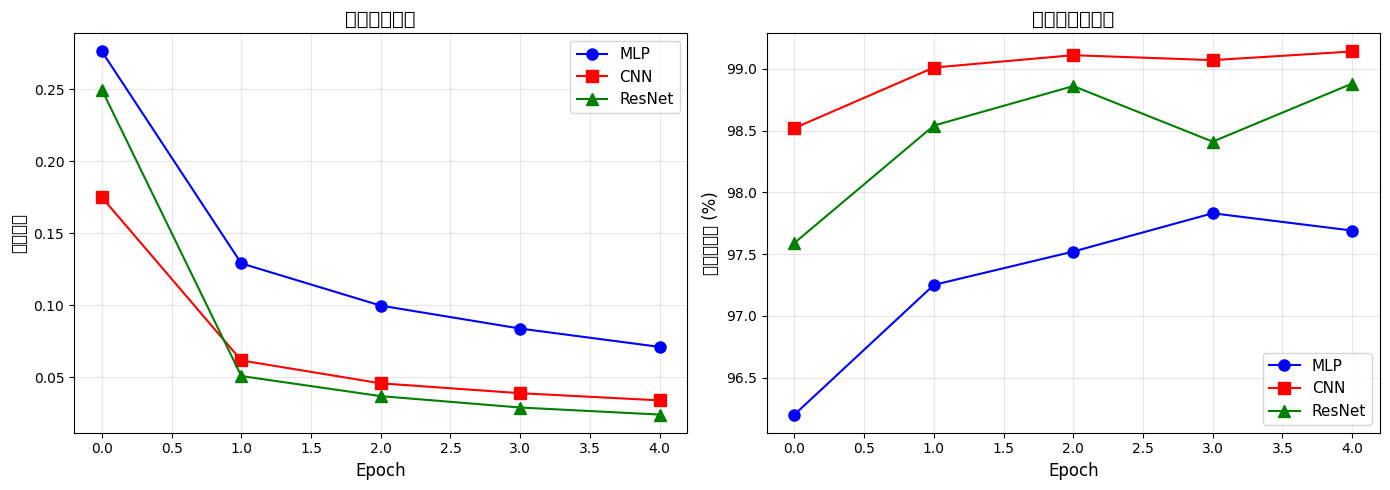

\n==================================================
          MNIST分类模型对比总结
模型         |        参数量 |      最终准确率
--------------------------------------------------
MLP        |    235,146 |     97.69%
CNN        |    421,642 |     99.14%
ResNet     |     77,754 |     98.88%


In [32]:
# ==================== 3.5 三种模型对比 ====================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 损失曲线对比
axes[0].plot(mlp_train_losses, 'b-o', label='MLP', markersize=8)
axes[0].plot(cnn_train_losses, 'r-s', label='CNN', markersize=8)
axes[0].plot(resnet_train_losses, 'g-^', label='ResNet', markersize=8)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('训练损失', fontsize=12)
axes[0].set_title('训练损失对比', fontsize=14)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# 准确率曲线对比
axes[1].plot(mlp_accuracies, 'b-o', label='MLP', markersize=8)
axes[1].plot(cnn_accuracies, 'r-s', label='CNN', markersize=8)
axes[1].plot(resnet_accuracies, 'g-^', label='ResNet', markersize=8)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('测试准确率 (%)', fontsize=12)
axes[1].set_title('测试准确率对比', fontsize=14)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 打印最终对比表格
print('\\n' + '='*50)
print('          MNIST分类模型对比总结')
print('='*50)
print(f'{"模型":<10} | {"参数量":>10} | {"最终准确率":>10}')
print('-'*50)
print(f'{"MLP":<10} | {sum(p.numel() for p in mlp_model.parameters()):>10,} | {mlp_accuracies[-1]:>9.2f}%')
print(f'{"CNN":<10} | {sum(p.numel() for p in cnn_model.parameters()):>10,} | {cnn_accuracies[-1]:>9.2f}%')
print(f'{"ResNet":<10} | {sum(p.numel() for p in resnet_model.parameters()):>10,} | {resnet_accuracies[-1]:>9.2f}%')
print('='*50)

---

## Part 4: YOLO目标检测实战

### 4.1 YOLO原理简介

**目标检测 vs 图像分类**:
- 分类: 图片里是什么？→ 一个类别
- 检测: 图片里有什么？在哪里？→ 多个物体 + 位置

**YOLO核心思想** (You Only Look Once):
- 将图片划分成 S×S 网格
- 每个网格预测: 边界框(x,y,w,h) + 置信度 + 类别概率
- 一次前向传播完成所有预测，速度快！

**关键概念**:
- **边界框 (Bounding Box)**: 用矩形框定位物体
- **置信度 (Confidence)**: 框内有物体的概率
- **IoU**: 预测框与真实框的重叠比例
- **NMS (非极大值抑制)**: 去除重复的框

In [33]:
# ==================== 4.2 安装和导入YOLO ====================

# 安装ultralytics（如果尚未安装）
# !pip install ultralytics
from ultralytics import YOLO
import cv2
from PIL import Image
import requests
from io import BytesIO

print('YOLO环境准备完成！')

YOLO环境准备完成！


### 4.3 实战一: 图片目标检测

In [34]:
# ==================== 4.3 加载预训练YOLO模型 ====================

# 加载YOLOv8n模型（nano版本，最小最快）
# 首次运行会自动下载预训练权重
model = YOLO('yolov8n.pt')

print('YOLOv8模型加载成功！')
print(f'模型可检测的类别数: {len(model.names)}')
print(f'部分类别示例: {list(model.names.values())[:10]}...')

100%|██████████| 6.25M/6.25M [00:08<00:00, 768kB/s] 


YOLOv8模型加载成功！
模型可检测的类别数: 80
部分类别示例: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light']...


In [35]:
# ==================== 4.4 下载示例图片并进行检测 ====================

def detect_image(image_source, model, conf_threshold=0.25):
    """
    对图片进行目标检测
    
    参数:
        image_source: 图片路径或URL
        model: YOLO模型
        conf_threshold: 置信度阈值，低于此值的检测结果会被过滤
    """
    # 进行检测
    # conf: 置信度阈值
    # verbose: 是否打印详细信息
    results = model(image_source, conf=conf_threshold, verbose=False)
    
    # 获取第一张图片的结果
    result = results[0]
    
    # 打印检测结果
    print('\\n========== 检测结果 ==========')
    boxes = result.boxes
    if len(boxes) == 0:
        print('未检测到任何物体')
    else:
        for i, box in enumerate(boxes):
            # 获取类别名称
            cls_id = int(box.cls[0])
            cls_name = model.names[cls_id]
            
            # 获取置信度
            confidence = float(box.conf[0])
            
            # 获取边界框坐标 (x1, y1, x2, y2)
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            
            print(f'{i+1}. {cls_name}: {confidence:.2%} | 位置: ({x1:.0f}, {y1:.0f}) - ({x2:.0f}, {y2:.0f})')
    
    return result

# 使用YOLO官方示例图片进行测试
# 这是一张包含多个人和公交车的街景图片
test_url = 'https://ultralytics.com/images/bus.jpg'

print('正在检测示例图片...')
result = detect_image(test_url, model)

正在检测示例图片...


100%|██████████| 134k/134k [00:00<00:00, 669kB/s]

\n========== 检测结果 ==========
1. bus: 87.34% | 位置: (23, 231) - (805, 757)
2. person: 86.57% | 位置: (49, 399) - (245, 903)
3. person: 85.28% | 位置: (669, 392) - (810, 877)
4. person: 82.52% | 位置: (222, 406) - (345, 858)
5. person: 26.11% | 位置: (0, 551) - (63, 873)
6. stop sign: 25.51% | 位置: (0, 254) - (33, 325)


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/opt/anaconda3/lib/python3.11/site-packages/IP

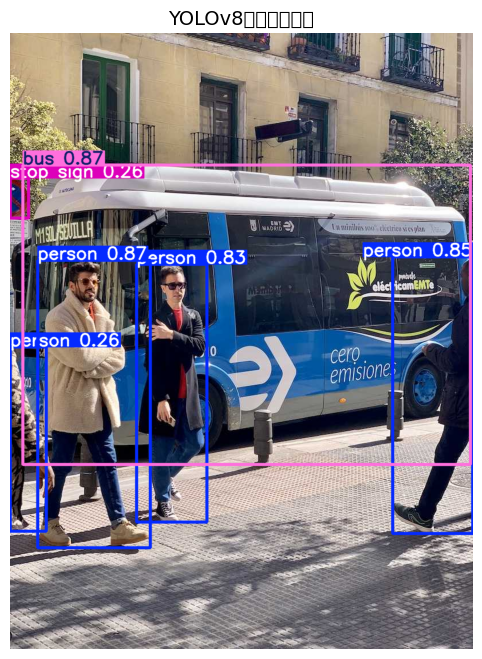

In [36]:
# ==================== 4.5 可视化检测结果 ====================

# 获取带有检测框的图片
# result.plot() 返回带有标注的图片数组(BGR格式)
annotated_img = result.plot()

# 将BGR转换为RGB用于matplotlib显示
annotated_img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

import matplotlib.pyplot as plt 
# 显示结果
plt.figure(figsize=(12, 8))
plt.imshow(annotated_img_rgb)
plt.title('YOLOv8目标检测结果', fontsize=14)
plt.axis('off')
plt.show()

正在检测第二张示例图片...


100%|██████████| 49.2k/49.2k [00:00<00:00, 529kB/s]
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: S

\n========== 检测结果 ==========
1. person: 83.60% | 位置: (115, 197) - (1114, 712)
2. person: 81.90% | 位置: (748, 42) - (1143, 713)
3. tie: 29.10% | 位置: (439, 437) - (524, 709)


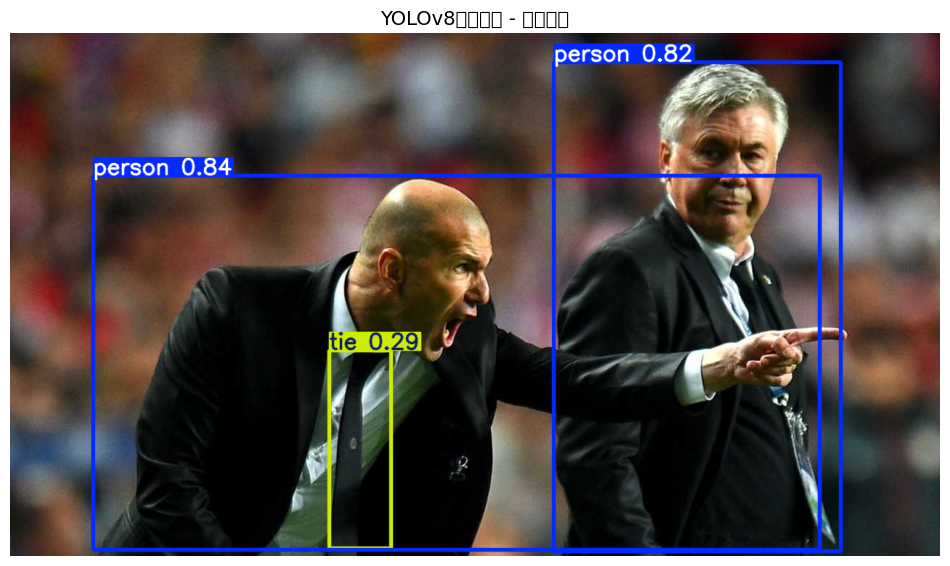

In [37]:
# ==================== 4.6 检测更多示例图片 ====================

# 测试另一张图片（斑马图片）
test_url2 = 'https://ultralytics.com/images/zidane.jpg'

print('正在检测第二张示例图片...')
result2 = detect_image(test_url2, model)

# 显示结果
annotated_img2 = result2.plot()
annotated_img2_rgb = cv2.cvtColor(annotated_img2, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 8))
plt.imshow(annotated_img2_rgb)
plt.title('YOLOv8检测结果 - 人物检测', fontsize=14)
plt.axis('off')
plt.show()

### 4.4 实战二: 视频/摄像头实时检测

> **注意**: 以下代码需要在本地环境运行，Jupyter中可能无法直接显示摄像头画面

In [38]:
# ==================== 4.7 视频/摄像头实时检测函数 ====================

def detect_video(source=0, model=None, show_fps=True):
    """
    对视频或摄像头进行实时目标检测
    
    参数:
        source: 视频源
                - 0: 默认摄像头
                - 1, 2...: 其他摄像头
                - 'video.mp4': 视频文件路径
        model: YOLO模型
        show_fps: 是否显示帧率
    
    操作:
        - 按 'q' 键退出
        - 按 's' 键保存当前帧
    """
    # 打开视频源
    cap = cv2.VideoCapture(source)
    
    if not cap.isOpened():
        print(f'无法打开视频源: {source}')
        return
    
    print('开始实时检测...')
    print('按 q 退出 | 按 s 保存当前帧')
    
    frame_count = 0
    
    while True:
        # 读取一帧
        ret, frame = cap.read()
        if not ret:
            print('视频结束或无法读取帧')
            break
        
        # 记录开始时间（用于计算FPS）
        start_time = cv2.getTickCount()
        
        # 进行检测
        results = model(frame, verbose=False)
        
        # 获取带标注的帧
        annotated_frame = results[0].plot()
        
        # 计算并显示FPS
        if show_fps:
            end_time = cv2.getTickCount()
            fps = cv2.getTickFrequency() / (end_time - start_time)
            cv2.putText(annotated_frame, f'FPS: {fps:.1f}', (10, 30),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        # 显示结果
        cv2.imshow('YOLO Detection', annotated_frame)
        
        # 键盘控制
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):  # 按q退出
            break
        elif key == ord('s'):  # 按s保存
            cv2.imwrite(f'detection_{frame_count}.jpg', annotated_frame)
            print(f'已保存: detection_{frame_count}.jpg')
        
        frame_count += 1
    
    # 释放资源
    cap.release()
    cv2.destroyAllWindows()
    print(f'检测结束，共处理 {frame_count} 帧')

# 注意: 在Jupyter中运行以下代码可能会有问题
# 建议在本地Python环境中运行
# 
# 使用摄像头:
# detect_video(source=0, model=model)
#
# 使用视频文件:
# detect_video(source='your_video.mp4', model=model)

print('视频检测函数已定义，可在本地环境中调用')

视频检测函数已定义，可在本地环境中调用


### 4.5 实战三：模型训练实战

前面我们使用的都是**预训练模型**（在大型数据集上训练好的模型）。对于一些特定的场景或特殊需求我们则需要自己训练模型。

**接下来你要实现如下的目标**:
1. 下载COCO128数据集
2. 从零开始训练一个目标检测模型
3. 测试训练好的模型效果
4. 理解数据集格式和训练流程

In [39]:
# ==================== 4.5.1 下载COCO128数据集 ====================

from ultralytics import YOLO
import os
import yaml

# COCO128是COCO数据集的迷你版本
# Ultralytics会自动下载和管理这个数据集
print('准备下载COCO128数据集...')

# 创建一个临时模型来触发数据集下载
# 使用coco128.yaml配置文件
model = YOLO('yolov8n.pt')

# 查看COCO128数据集的配置
# Ultralytics将数据集下载到用户目录下的datasets文件夹
data_yaml_path = 'coco128.yaml'

print('='*50)
print('下载完成')
print('='*50)

准备下载COCO128数据集...
下载完成


In [40]:
# ==================== 4.5.2 训练模型 ====================

print('='*50)
print('          开始训练YOLO模型')
print('='*50)

# 加载预训练的YOLOv8n模型作为起点（迁移学习）
# 这比从零开始训练要快得多，效果也更好
model = YOLO('yolov8n.pt')

# 开始训练
results = model.train(
    data='coco128.yaml',      # 使用COCO128数据集
    epochs=10,                 # 训练10轮（演示用，实际项目建议至少50-100轮）
    imgsz=640,                 # 输入图片尺寸
    batch=16,                  # 批次大小（根据显存调整）
    patience=5,                # 5轮无改善则早停
    save=True,                 # 保存模型
    project='runs/train',      # 保存目录
    name='coco128_demo',       # 实验名称
    verbose=True               # 显示详细信息
)

print('\n' + '='*50)
print('          训练完成')
print('='*50)
# 训练结果保存在: runs/train/coco128_demo/
# 包含:
#  - weights/best.pt: 最佳模型权重
#  - weights/last.pt: 最后一轮权重
#  - results.png: 训练曲线图
#  - confusion_matrix.png: 混淆矩阵

          开始训练YOLO模型
New https://pypi.org/project/ultralytics/8.3.233 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.140 🚀 Python-3.11.7 torch-2.3.1 CPU (Apple M2 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=coco128.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=coco128_demo, nbs=64, nms=False, opset=None, optimize=False, op

100%|██████████| 6.66M/6.66M [00:02<00:00, 2.64MB/s]
Unzipping /Users/xin/Documents/GithubTemp/datasets/coco128.zip to /Users/xin/Documents/GithubTemp/datasets/coco128...: 100%|██████████| 263/263 [00:00<00:00, 3592.07file/s]

Dataset download success ✅ (4.1s), saved to /Users/xin/Documents/GithubTemp/datasets




                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

train: Scanning /Users/xin/Documents/GithubTemp/datasets/coco128/labels/train2017... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<00:00, 3385.45it/s]

train: New cache created: /Users/xin/Documents/GithubTemp/datasets/coco128/labels/train2017.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1561.8±612.2 MB/s, size: 52.5 KB)


val: Scanning /Users/xin/Documents/GithubTemp/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]


Plotting labels to runs/train/coco128_demo/labels.jpg... 


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/train/coco128_demo
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.161       1.33      1.184         78        640: 100%|██████████| 8/8 [00:54<00:00,  6.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:21<00:00,  5.30s/it]

                   all        128        929      0.662      0.533      0.613      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.146       1.28      1.181         97        640: 100%|██████████| 8/8 [00:47<00:00,  5.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:21<00:00,  5.26s/it]

                   all        128        929      0.674      0.579      0.636      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/10         0G      1.144      1.299      1.189        110        640: 100%|██████████| 8/8 [00:46<00:00,  5.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:21<00:00,  5.28s/it]

                   all        128        929      0.666      0.579      0.643       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/10         0G      1.171      1.292      1.191         87        640:  62%|██████▎   | 5/8 [00:37<00:22,  7.41s/it]


KeyboardInterrupt: 

In [ ]:
# ==================== 4.5.3 测试训练好的模型 ====================

# 加载刚才训练的最佳模型
trained_model = YOLO('runs/train/coco128_demo4/weights/best.pt')

# 使用训练好的模型检测图片
test_results = trained_model('https://ultralytics.com/images/bus.jpg', conf=0.25, verbose=False)

# 打印检测结果
print('========== 检测结果 ==========')
boxes = test_results[0].boxes
if len(boxes) == 0:
    print('未检测到任何物体')
else:
    for i, box in enumerate(boxes):
        cls_id = int(box.cls[0])
        cls_name = trained_model.names[cls_id]
        confidence = float(box.conf[0])
        print(f'{i+1}. {cls_name}: {confidence:.2%}')

# 可视化检测结果
annotated_trained = test_results[0].plot()
annotated_trained_rgb = cv2.cvtColor(annotated_trained, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 8))
plt.imshow(annotated_trained_rgb)
plt.title('使用训练好的模型进行检测', fontsize=14)
plt.axis('off')
plt.show()

### 4.5.4 YOLO数据集格式

为了能够获得自己的数据集，我们需要了解YOLO的数据集格式。

**标准目录结构**:
```
dataset/
├── images/
│   ├── train/          # 训练集图片
│   │   ├── img001.jpg
│   │   ├── img002.jpg
│   │   └── ...
│   └── val/            # 验证集图片
│       ├── img001.jpg
│       └── ...
├── labels/
│   ├── train/          # 训练集标注（与图片一一对应）
│   │   ├── img001.txt
│   │   ├── img002.txt
│   │   └── ...
│   └── val/            # 验证集标注
│       ├── img001.txt
│       └── ...
└── data.yaml           # 数据集配置文件
```

**标注文件格式** (每行一个物体):
```
class_id center_x center_y width height
```

**重要**: 所有坐标都是**归一化值** (0-1之间):
- `center_x` = 物体中心x坐标 / 图片宽度
- `center_y` = 物体中心y坐标 / 图片高度
- `width` = 物体宽度 / 图片宽度
- `height` = 物体高度 / 图片高度

**标注示例** (假设图片尺寸800×600):
```
0 0.5 0.5 0.3 0.4    # 类别0, 中心(400,300), 宽240, 高240
1 0.2 0.3 0.1 0.2    # 类别1, 中心(160,180), 宽80, 高120
```

In [ ]:
# ==================== 4.5.5 data.yaml配置文件示例 ====================
# data.yaml负责告诉YOLO数据在哪里，有哪些类别

# 数据集根目录（可以是绝对路径或相对路径）
path: ./my_dataset

# 训练集和验证集的相对路径（相对于path）
train: images/train  # 训练集图片文件夹
val: images/val      # 验证集图片文件夹
# 注意：labels文件夹会自动对应，无需指定

# 类别数量（必须与实际类别数量一致）
nc: 2

# 类别名称（索引从0开始，用于显示检测结果）
names:
  0: cat
  1: dog

# 1. 将此文件保存为 data.yaml
# 2. 确保path路径正确指向你的数据集
# 3. train/val 是相对于path的路径
# 4. nc 必须等于实际的类别数量
# 5. names 中的索引要与标注文件中的class_id对应

### 4.5.6 训练自己数据集的步骤

**1: 收集图片**
- 每个类别至少100张图片（越多越好）
- 图片质量要好，光线、角度多样化
- 确保包含各种场景和背景

**2: 标注数据**
可以使用标注工具，几种常见的数据集标注工具:
- **LabelImg**: 简单易用
- **Roboflow**: 在线标注，自动转换格式
- **CVAT**: 功能强大，适合团队协作

**3: 整理数据集**
按照上面的目录结构组织文件，创建data.yaml

**4: 开始训练**
使用下面的训练代码模板

**注：不要直接运行下面的这个代码块，你需要先完成相关的配置才能开始训练自己的数据集**

In [ ]:
# ==================== 4.5.7 自定义数据集训练代码模板 ====================

# 训练技巧：
# 1. 从小模型开始（yolov8n），确保流程正确
# 2. 先用少量epochs测试（如10轮），验证数据集正确
# 3. 监控训练曲线，避免过拟合
# 4. 根据显存调整batch_size（8/16/32）
# 5. 如果准确率不够，尝试更大的模型或更多数据

from ultralytics import YOLO

# ========== 1: 加载预训练模型 ==========
model = YOLO('yolov8n.pt')  # nano版本，最小，速度快
# 或选择其他版本：
# model = YOLO('yolov8s.pt')  # small - 较小，速度较快
# model = YOLO('yolov8m.pt')  # medium - 平衡性能和速度
# model = YOLO('yolov8l.pt')  # large - 最准确但最慢

# ========== 步骤2: 开始训练 ==========
results = model.train(
    # ===== 必需参数 =====
    data='path/to/your/data.yaml',  # 改为你的data.yaml路径
    
    # ===== 训练参数 =====
    epochs=100,              # 训练轮数（建议50-200）
    imgsz=640,               # 输入图片尺寸（640是标准）
    batch=16,                # 批次大小（根据显存调整：8/16/32）
    
    # ===== 优化参数 =====
    patience=20,             # 早停耐心值（20轮无改善则停止）
    lr0=0.01,                # 初始学习率
    optimizer='Adam',        # 优化器 (Adam/SGD/AdamW)
    
    # ===== 数据增强 =====
    hsv_h=0.015,            # 色调增强
    hsv_s=0.7,              # 饱和度增强
    hsv_v=0.4,              # 亮度增强
    degrees=0.0,            # 旋转角度
    translate=0.1,          # 平移
    scale=0.5,              # 缩放
    flipud=0.0,             # 上下翻转概率
    fliplr=0.5,             # 左右翻转概率
    mosaic=1.0,             # mosaic增强概率
    
    # ===== 保存设置 =====
    save=True,              # 保存检查点
    save_period=10,         # 每10轮保存一次
    project='runs/train',   # 保存根目录
    name='my_custom_model', # 实验名称
    exist_ok=False,         # 如果名称存在是否覆盖
    
    # ===== 硬件设置 =====
    device=0,               # GPU设备（0/1/2或'cpu'）
    workers=8,              # 数据加载线程数
    
    # ===== 其他 =====
    verbose=True,           # 显示详细信息
    resume=False,           # 是否从上次中断处继续
)

# ========== 步骤3: 评估模型 ==========
metrics = model.val()
print(f'\n评估指标：')
print(f'mAP50: {metrics.box.map50:.3f}      # IoU阈值0.5时的平均精度')
print(f'mAP50-95: {metrics.box.map:.3f}   # IoU从0.5到0.95的平均精度（更严格）')
print(f'Precision: {metrics.box.mp:.3f}   # 精确率（检测到的物体中有多少是正确的）')
print(f'Recall: {metrics.box.mr:.3f}      # 召回率（实际物体中有多少被检测到）')

# ========== 步骤4: 使用训练好的模型进行推理 ==========
best_model = YOLO('runs/train/my_custom_model/weights/best.pt')
test_results = best_model('test_image.jpg')  # 改为你的测试图片路径
test_results[0].show()  # 显示结果

# ========== 步骤5: 导出模型（可选） ==========
# 导出为其他格式以便部署
best_model.export(format='onnx')   # ONNX格式，跨平台
# best_model.export(format='torchscript')  # TorchScript
# best_model.export(format='coreml')       # CoreML (iOS)
# best_model.export(format='tflite')       # TensorFlow Lite (移动端)

### 4.6 YOLO其他功能演示

YOLOv8不仅支持目标检测，还支持:
- **分割 (Segmentation)**: 像素级别的物体分割
- **姿态估计 (Pose)**: 人体关键点检测
- **分类 (Classification)**: 图像分类

In [ ]:
# ==================== 4.9 实例分割演示 ====================

# 加载分割模型
seg_model = YOLO('yolov8n-seg.pt')

# 对示例图片进行分割
seg_results = seg_model('https://ultralytics.com/images/bus.jpg', verbose=False)

# 可视化分割结果
seg_img = seg_results[0].plot()
seg_img_rgb = cv2.cvtColor(seg_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 8))
plt.imshow(seg_img_rgb)
plt.title('YOLOv8实例分割结果', fontsize=14)
plt.axis('off')
plt.show()

In [ ]:
# ==================== 4.10 姿态估计演示 ====================

# 加载姿态估计模型
pose_model = YOLO('yolov8n-pose.pt')

# 对示例图片进行姿态估计
pose_results = pose_model('https://ultralytics.com/images/bus.jpg', verbose=False)

# 可视化姿态估计结果
pose_img = pose_results[0].plot()
pose_img_rgb = cv2.cvtColor(pose_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 8))
plt.imshow(pose_img_rgb)
plt.title('YOLOv8姿态估计结果', fontsize=14)
plt.axis('off')
plt.show()

---

## Part 5: 课程总结

### 知识点回顾

```
MNIST数据集
    │
    ├── 全连接网络 (MLP)
    │     └── 简单直接，但参数多
    │
    ├── 卷积神经网络 (CNN)
    │     └── 卷积+池化，参数共享，效果更好
    │
    └── 残差网络 (ResNet)
          └── 残差连接，可训练深层网络

YOLO目标检测
    │
    ├── 图片检测 - 静态图片物体识别
    ├── 视频/实时检测 - 摄像头实时识别
    ├── 实例分割 - 像素级物体分割
    └── 姿态估计 - 人体关键点检测
```

### 延伸学习资源

- **PyTorch官方教程**: https://pytorch.org/tutorials/
- **Ultralytics文档**: https://docs.ultralytics.com/
- **动手学深度学习**: https://zh.d2l.ai/

### 下一步建议

1. 尝试修改网络结构，观察准确率变化
2. 用YOLO检测自己拍摄的照片
3. 收集数据训练自己的检测模型